Note: While in the earlier editions of Kernel , I was trying to create a basic model , however since I have been using Bokeh for analysis , it requires internet , rendering the modelling useless if done in the same notebook.

<div class="list-group" id="list-tab" role="tablist" >
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Table of Contents</h3>
  <a span style ="color:orange" class="list-group-item list-group-item-action" data-toggle="list" href="#data" role="tab" aria-controls="profile">Introduction to Riids Competition<span class="badge badge-primary badge-pill">1</span></a>
    <a span style ="color:orange" class="list-group-item list-group-item-action" data-toggle="list" href="#data" role="tab" aria-controls="profile"> References <span class="badge badge-primary badge-pill">2</span></a>
  <a span style ="color:orange" class="list-group-item list-group-item-action" data-toggle="list" href="#down" role="tab" aria-controls="messages">Basic EDA and Insights so far<span class="badge badge-primary badge-pill" >3</span></a>
 

# <a id='data' span style="color:orange">Introduction to Riids Competition</a>
The competition has been quite interesting so far, and there still remains room for more improvement.
In this competition , we have been given tabular data , and it seems to be the case of supervised learning problem.

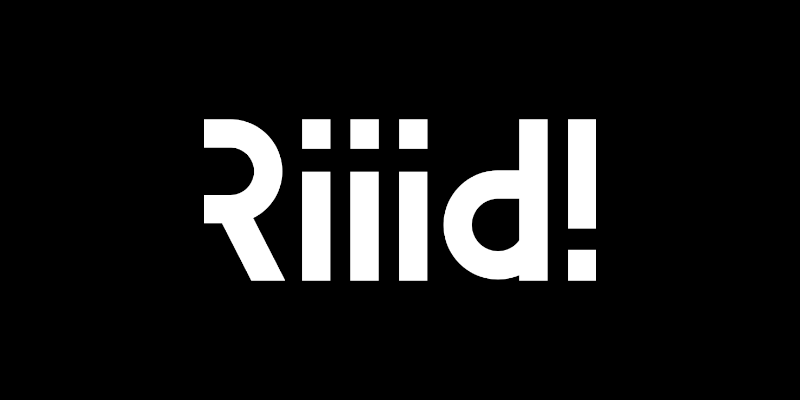

 # <a id='data' span style="color:orange">References</a>
First and foremost I want to acknowlegde the notebooks which I have taken the inspiration from to create this notebook. If you consider upvoting this notebook , please upvote these as well. I would highly encourage you to read them to get the gist of the problem  :
 
 https://www.kaggle.com/erikbruin/riiid-comprehensive-eda-baseline
 
 https://www.kaggle.com/isaienkov/riiid-answer-correctness-prediction-eda-modeling
 
 https://www.kaggle.com/carlmcbrideellis/riiid-eda-and-feature-importance

# <a id='data' span style="color:orange">Basic EDA and Insights so far</a>

 ## <span style= color:Aquamarine> Small Summary of Data 
We have been given `Train.csv` which contains the data which is in relation to the user , `questions.csv` contains all the data with regards to the questions which are posed to the user , `lectures.csv` contains all the data with regards to lectures , in the `test data` there seems to be the same data as train.csv but it includes two more rows `prior_group_responses` and `prior_group_answers_correct`i.e it contains data of user with regards to his previous performance and how many questions he has responded correctly . Thus the task is to  predict how a user would fare to a new question when we have been provided his past data.

For detailed information of the csvs: https://www.kaggle.com/c/riiid-test-answer-prediction/data

We import the required libraries and use the pickle which had been generously created by @Vopani

In [ ]:
!pip install pandas-bokeh

In [ ]:
import pandas as pd
import numpy as np
from bokeh.io import output_file,show,output_notebook,push_notebook
import pandas_bokeh
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,HoverTool,CategoricalColorMapper
from bokeh.layouts import row,column,gridplot
from bokeh.models.widgets import Tabs,Panel,DataTable, TableColumn
from bokeh.palettes import Spectral3
output_notebook()
pandas_bokeh.output_notebook()
pd.set_option('plotting.backend', 'pandas_bokeh')


## *Loading Train Data*

In [ ]:
%%time

train = pd.read_pickle("../input/riiid-train-data-multiple-formats/riiid_train.pkl.gzip")

print("Train size:", train.shape)
p=train.head(30)
p.style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

In [ ]:
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('bool')

train.memory_usage(deep=True)

My insight on this : 
So one of thing I have noticed is that the values are in multiples of each other , if you look carefully. When we just look at the compelete dataframe , while unique values might be different, row_id is 2 times user_id , which might show that at two transactions were taken per user atleast.So let's check the different hypothesis which can be made from the same .

In [ ]:
print(f"Total unique users are {train.user_id.nunique()}")
print(f"However the total interactions which seem to be recorded are {len(train.user_id)}")
x=len(train.user_id)/train.user_id.nunique()
print("On average the interactions of a user should be",x) 
print(train.user_id.value_counts())

The data shows how some users have way more interactions while studying , while some users have quite less interactions. The data is skewed , some questions which I am now thinking about are :
1.) Our predictions will vary with regards to how much user has already interacted with platform , but one hypotheses which should be tested with regards if he faces a new topic or new user interacts with the question to check the prediction should we keep the threshold with regards to how new users performed.

In [ ]:
Users=pd.DataFrame(train.user_id.value_counts())
Users=Users[:10]
Users.head()
Users=Users.rename(columns={"user_id" :"Interactions"})
from bokeh.palettes import RdYlGn
Users['color'] = RdYlGn[len(Users)]
p_bar = Users.plot_bokeh.bar(
   ylabel="No of Interaction", 
   title="Top 10 Most Interactive Users",
   alpha=0.6,fill_color='color',line_color="white",fontsize_title="18pt",fontsize_label="16pt",figsize=(1200,800),fontsize_ticks="14pt",hatch_pattern="vertical_wave",hatch_color="white"
    )
    

In [ ]:
print(sum(train.user_id.value_counts() == 1))
print(sum(train.user_id.value_counts() <= 258))


So only 87 users are it seems having only one interaction, and more than 320000 users are having less than what was supposed average amount of interactions , so should all the values above the threshold i.e some 10.000 values be considered as outliers !! 

In [ ]:
x=train.describe()
# Import seaborn library 
y=x.drop(['count'])
import seaborn as sns 
cm = sns.light_palette("blue", as_cmap=True) 
y.style.background_gradient(cmap=cm).set_precision(2)

Looking at train describe, we can see how almost 63% percent of questions are correctly answered. So , if we can try to keep predictions for unknown target at a baseline of 0.6 .

In [ ]:
%%time

questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
lectures = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')
example_test = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_test.csv')
example_sample_submission = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv')
l=example_sample_submission.head()
l.style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

# <span style= color:Navy>Checking Question Data

In [ ]:
e=questions.head()
e.style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

In [ ]:
print(f"We have {questions.question_id.nunique()} questions for training")

In [ ]:
print(questions.bundle_id.value_counts())
print(f"We have {questions.question_id.nunique()} questions for training which are divided in {questions.bundle_id.nunique()} bundles")

In [ ]:
bundle=pd.DataFrame(questions.bundle_id.value_counts())
bundle=bundle[:15]
bundle.head()
bundle=bundle.rename(columns={"bundle_id" :"Times used"})
from bokeh.palettes import Category20c
bundle['color'] = Category20c[len(bundle)]

p_bar = bundle.plot_bokeh.bar(
   ylabel="No of Interaction", 
   title="Top 15 Bundles Used",
   alpha=0.6,fill_color='color',line_color="white",fontsize_title="18pt",fontsize_label="16pt",figsize=(1200,800),fontsize_ticks="14pt",hatch_pattern="vertical_wave",hatch_color="white"
    )
    

In [ ]:
print(f"Unique bundles of tags {questions.tags.nunique()} which are given to question")

Hi, I have taken this code directly from Erik's notebook .

In [ ]:
questions['tags'] = questions['tags'].astype(str)

tags = [x.split() for x in questions[questions.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
print(f'There are total {len(tags)} different tags')
print

So there are 1519 different bundles of tags which are made with 188 tags , we can try to find which tags are more related to each other perhaps as use tags correlation to understand the the question. I have to furthur explore this aspect . Just looking at head you can see how 9, 10 are more related and even 131 and 162 seem to be more correlated 

In [ ]:
print(questions.tags[:50])

Note : I still have to also check with regards to Part , while related to TOEIC , it also seems to be important 

# <span style= color:coral>Checking Lectures Data 

In [ ]:
w=lectures.head(5)
w.style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

In [ ]:
print(f"We have {lectures.lecture_id.nunique()} different lectures")

In [ ]:
lectures['tag'] = lectures['tag'].astype(str)

tag = [x.split() for x in lectures[lectures.tag != "nan"].tag.values]
tag = [item for elem in tag for item in elem]
tag = set(tag)
tag = list(tag)
print(f'There are total {len(tag)} different tags')
print(tag)

Thus , it seems that there are 151 lectures tags and 188 different question tags.Moreover the tags on the lectures seem to be unrelated , one lecture seems to have one tag which is very interesting .

In [ ]:
print(lectures.tag.value_counts())
y=len(lectures.tag)/lectures.tag.nunique()
print("We can check the average to see that how much some lecture are overused", y )
print(sum(lectures.tag.value_counts() == 1))
print(sum(lectures.tag.value_counts() >= 2.7))

In [ ]:
z=pd.DataFrame(lectures.type_of.value_counts())
z.style.background_gradient(cmap='Greens_r').set_precision(2)

## <span style=color:Coral>Analyzing Time-series Data
    
Well , one of the most interesting findings which can be explored with respect to the competition seems to be analyzing the time-series data and even getting the different properties of the question which can be helped in creating the questions .
    

In the description, timestamp is decribed as the time in milliseconds between this user interaction and the first event completion from that user.
So perhaps it could mean that user is required to do a event(i.e lecture or answers questions when he first joins the site.)

In [ ]:
time=train.timestamp
time.value_counts()

In [ ]:
prior_questions=train[["prior_question_elapsed_time" ,"prior_question_had_explanation"]]
prior_questions.head()

In [ ]:
prior_questions.prior_question_had_explanation.value_counts()

In [ ]:
from math import pi
from bokeh.io import output_file, show
from bokeh.palettes import RdYlBu,Viridis
from bokeh.plotting import figure
from bokeh.transform import cumsum
z = {
    "Yes": 89685560,
    "No":11544772
}

data = pd.Series(z).reset_index(name='value').rename(columns={'index':'country'})
data['angle'] = data['value']/data['value'].sum() * 2*pi
data['color'] = ["Green","Darkred"]

p = figure(plot_height=350, title="Previous Questions had explanations", toolbar_location=None,
           tools="hover", tooltips="@country: @value", x_range=(-0.5, 1.0),background_fill_color="beige")

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='country', source=data)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None
p.title.text_color = "midnightblue"
p.title.text_font = "times"
p.title.text_font_style = "italic"
p.title.text_font_size = "18pt"
show(p)

In [ ]:
pq=pd.DataFrame(prior_questions.prior_question_elapsed_time.value_counts())
pl=pq.head(15)
px=pl.sort_index()
px=px.rename(columns={"Time_elapsed" :"Value"})
from bokeh.palettes import Category20c
px['color'] = Category20c[len(px)]

p_bar = px.plot_bokeh.bar(
  ylabel="No of Interaction", 
  title="Top 10 Time Values Used",
  alpha=0.6,fill_color='color',line_color="white",fontsize_title="18pt",fontsize_label="16pt",figsize=(1200,800),fontsize_ticks="14pt",hatch_pattern="vertical_wave",hatch_color="white"
    )


One of the interesesting thing about this graphs is that perhpaes on medain people take 17 milliseconds to answer the question , whereas I was expecting a downward sloping curver forthe the questions , however a lot of questions take higher time on average and how data is skewed right shows that .

### Fin

While this is a quick eda , there still seems to be many areas for inspecting , feature tag can be checked for correlation with question and even with respect to other tags to understand what kind of relations do they have .
While lectures tags are a bit different , these tags seem to be the kind of topics , however lectures having different tags is a bit unexpected . 
### <span style = color:Salmon> If you liked the notebook, please upvote , but more importantly please drop down suggestions/critiques, I would love to improve on those areas !! 

Link for my modelling notebook:
https://www.kaggle.com/sahilmaheshwari/making-ensemble-of-catboost-and-lgbm